# Mini-hackathon with the Credit Assignment Project (Open scope)

## Installation

The git repo is accessible here, to follow the hackathon on your own laptop follow the installation instructions:

[https://github.com/colleenjg/OpenScope_CA_Analysis/tree/minihack]()

Clone the github branch `minihack`:

```bash
git clone git@github.com:colleenjg/OpenScope_CA_Analysis.git
cd OpenScope_CA_Analysis
git switch minihack
```

Follow the installation using `conda` detailed in the README in the root directory
(takes ~3-4 minutes to install pip dependencies):
```bash
conda env create -f osca.yml
conda activate osca
```

To download the data for mouse number 4 (3 session per mouse, ~750MB for mouse 4, ~15GB for all mice), from the root directory of the repo do:
(takes ~10 minutes to download the three sessions of mouse 4 with EPFL wifi, faster with ethernet cable)
```bash
python sess_util/sess_download_util.py --output "../datasets/osca/" --mouse_ns 4
```

In [1]:
from pathlib import Path

from util import gen_util, logger_util, plot_util
gen_util.extend_sys_path(Path("").resolve(), parents=1)

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd

from minihack.load_data import get_calcium_traces, get_mouse_df, CONDITIONS

# 1) Set some initial variables and parameters

In [2]:
logger_util.format_all(level="info") # set logging level
plot_util.linclab_plt_defaults() # set plotting defaults
pd.options.display.max_columns = None # show all dataframe columns
dataset_path = Path("../datasets/osca/") # set path to the dataset

In [3]:
if not dataset_path.is_dir():
    raise ValueError(f"{dataset_path} not found.")

# 2) Explore the dataset

The mouse dataframe saved as `mouse_df.csv` gives a quick overview of the dataset. Each row corresponds to a recording session, and in most cases the same mouse is imaged for three sessions recorded over three days. In the following, we display the data from the `prod` runtype (the subset shared online) and that have passed (`P`) quality control.

In [4]:
df = get_mouse_df()
df = df[(df["runtype"] == "prod") & (df["pass_fail"] == "P")]
df

,sessid,full_timestamp,mouse_n,mouseid,sex,DOB,date,age_weeks,depth,plane,line,runtype,sess_n,nrois,nrois_tracked,nrois_all,nrois_allen,nrois_allen_all,pass_fail,all_files,any_files,incl,stim_seed,notes
33,758519303,20180926T172917,1,408021,M,20180623,20180926,13.571429,175,soma,L23-Cux2,prod,1,96,59,116,96,116,P,1,1,yes,30587,NaN
34,759189643,20180927T182632,1,408021,M,20180623,20180927,13.714286,175,soma,L23-Cux2,prod,2,74,59,86,74,86,P,1,1,yes,5730,NaN
35,759660390,20181001T172833,1,408021,M,20180623,20181001,14.285714,175,soma,L23-Cux2,prod,3,107,59,121,107,121,P,1,1,yes,36941,NaN
39,761730740,20181009T175037,2,411400,F,20180711,20181009,12.857143,20,dend,L5-Rbp4,prod,4,630,162,657,57,65,P,1,1,yes,44023,NaN
40,762415169,20181011T174057,2,411400,F,20180711,20181011,13.142857,20,dend,L5-Rbp4,prod,5,637,162,662,25,31,P,1,1,yes,29259,NaN
41,763646681,20181015T173410,2,411400,F,20180711,20181015,13.714286,20,dend,L5-Rbp4,prod,6,597,162,602,33,44,P,1,1,yes,1118,NaN
42,761624763,20181009T152254,3,411424,F,20180711,20181009,12.857143,175,soma,L23-Cux2,prod,1,87,55,96,87,96,P,1,1,yes,997,NaN
43,761944562,20181010T160230,3,411424,F,20180711,20181010,13.000000,175,soma,L23-Cux2,prod,2,90,55,94,90,94,P,1,1,yes,33856,"dropped stim frames (17), 2nd stim2twop alignm..."
44,762250376,20181011T155936,3,411424,F,20180711,20181011,13.142857,175,soma,L23-Cux2,prod,3,80,55,88,80,88,P,1,1,yes,23187,NaN
45,760260459,20181003T174857,4,411771,M,20180713,20181003,11.714286,375,soma,L5-Rbp4,prod,1,90,47,104,90,104,P,1,1,yes,33767,NaN


We can also specifically select the sessions where the somata of L5 pyramidal neurons are recorded.
I find three mice in this case: 4, 7, and 12. Each of them typically has 3 recording sessions.

In [5]:
sub_df = df[(df["plane"] == "soma") & (df["line"]=="L5-Rbp4")]
print(f"Mice: {sub_df['mouse_n'].unique().tolist()}")
sub_df

Mice: [4, 7, 12]


,sessid,full_timestamp,mouse_n,mouseid,sex,DOB,date,age_weeks,depth,plane,line,runtype,sess_n,nrois,nrois_tracked,nrois_all,nrois_allen,nrois_allen_all,pass_fail,all_files,any_files,incl,stim_seed,notes
45,760260459,20181003T174857,4,411771,M,20180713,20181003,11.714286,375,soma,L5-Rbp4,prod,1,90,47,104,90,104,P,1,1,yes,33767,NaN
46,760659782,20181004T173816,4,411771,M,20180713,20181004,11.857143,375,soma,L5-Rbp4,prod,2,70,47,76,70,76,P,1,1,yes,32698,NaN
47,761269197,20181008T172946,4,411771,M,20180713,20181008,12.428571,375,soma,L5-Rbp4,prod,3,79,47,99,9,99,P,1,1,yes,17904,NaN
57,777496949,20181113T015148,7,418779,F,20180820,20181112,12.000000,375,soma,L5-Rbp4,prod,1,15,12,31,15,31,P,1,1,yes,32706,NaN
58,778374308,20181114T030141,7,418779,F,20180820,20181113,12.142857,375,soma,L5-Rbp4,prod,2,26,12,56,26,56,P,1,1,yes,8114,NaN
59,779152062,20181115T010609,7,418779,F,20180820,20181114,12.285714,375,soma,L5-Rbp4,prod,3,29,12,55,29,55,P,1,1,yes,11744,NaN
73,826659257,20190221T162838,12,433458,M,20181106,20190221,15.285714,375,soma,L5-Rbp4,prod,1,99,70,126,99,126,P,1,1,yes,35969,NaN
74,827300090,20190222T161948,12,433458,M,20181106,20190222,15.428571,375,soma,L5-Rbp4,prod,2,87,70,107,87,107,P,1,1,yes,10378,NaN
75,828475005,20190225T162214,12,433458,M,20181106,20190225,15.857143,375,soma,L5-Rbp4,prod,3,97,70,118,97,118,P,1,1,yes,10576,"z-drift (10 um), passed QC after revision"
76,829520904,20190227T162140,12,433458,M,20181106,20190227,16.142857,375,soma,L5-Rbp4,prod,4,88,-1,109,88,109,P,1,1,yes,42270,NaN


# 3) Extract the calcium traces as a tensor

We use a little custom function which extracts the calcium traces for each ROI (i.e., neuron cell body or dendritic segment), and returns relevant data:
  * `sess`: the session object
  * `roi_indices`: an array containing the indices of the different ROIs
  * `roi_timestamps`: an array containing the relative times for each segment
  * `roi_data`: the calcium traces as a tensor of dim (# trials x # segs x # frames x # ROIs)
  * `gabor_seg_dict`: dictionary with segment information for each trial
     * `'gabor_frame'`: an array specifying Gabor frames (# trial x # segs)
     * `'gabor_mean_orientation'`: an array specifying Gabor orientations (# trial x # segs)
     * `'unexpected'`: an array specifying whether a segment is part of an expected or unexpected sequence (# trial x # segs)

In [6]:
sess, roi_indices, roi_timestamps, roi_data, gabor_seg_dict = get_calcium_traces(
    sess_n=1, 
    mouse_n=4, 
    tracked=False, 
    dataset_path=dataset_path
)


    Session: M4 S1 (L5-Rbp4 soma)
Loading stimulus and alignment info...
Loading ROI trace info...
Loading data for Gabor stimulus...


In this notebook, we do not directly use the Session object (`sess`). However, it should be noted that it has many attributes and methods that could be of interest. A few examples are provided below.   
_**Note:** See `../examples/session_demonstration_script.ipynb` for more details on using the Session object directly._

Mouse:  4
Session:  1
Date:  20181003
Recording plane:  L5-Rbp4 soma
Stimuli
Gabors (stimulus from session 760260459)
Visflow (stimulus from session 760260459)


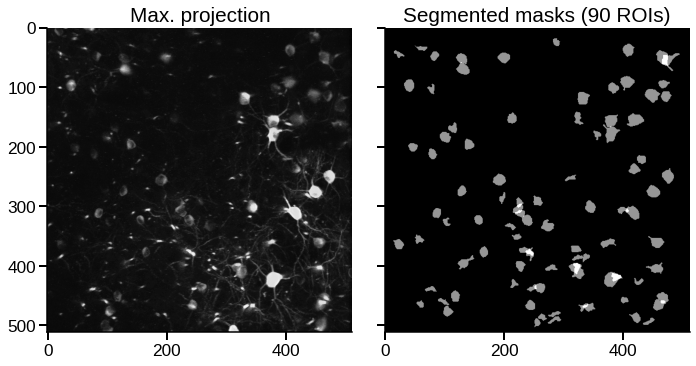

In [7]:
print("Mouse: ", sess.mouse_n) # mouse number for the session
print("Session: ",sess.sess_n) # session number for the mouse
print("Date: ",sess.date) # recording day
print("Recording plane: ",sess.line, sess.plane) # recording line and plane

print("Stimuli")
for stim in sess.stims: # Stimulus object comprised in the Session object
    print(stim)
    
# Retrieve and plot the maximum projection image for the session
fig, ax = plt.subplots(1, 2, figsize=[10, 5], sharex=True, sharey=True)
ax[0].imshow(sess.max_proj, cmap="Greys_r")
ax[0].set_title("Max. projection")

# Retrieve and plot the ROI masks for the session
roi_masks = sess.get_roi_masks()
ax[1].imshow(roi_masks.sum(axis=0), cmap="Greys_r")
ax[1].set_title(f"Segmented masks ({len(roi_masks)} ROIs)");

The following function will print an overview of the data returned by `get_calcium_traces()`.

In [8]:
def print_data_overview(sess, roi_indices, roi_timestamps, roi_data, gabor_seg_dict):
    print("DATA OVERVIEW")
    tensor_names = ["ROI indices", "ROI timestamps", "ROI data"]
    tensors = [roi_indices, roi_timestamps, roi_data]
    for t, t_name in enumerate(tensor_names + list(gabor_seg_dict.keys())):
        if t_name in gabor_seg_dict.keys():
            tensor = gabor_seg_dict[t_name]
            t_name = t_name.capitalize().replace("_", " ") # capitalize and replace '_' characters with spaces
        else:
            tensor = tensors[t]

        print(
            f"\n{t_name}:\n    {tensor.dtype}, shape {tensor.shape}\n"
            f"    example vals: {np.unique(tensor)[:3].tolist()}"
        )

In [9]:
print_data_overview(sess, roi_indices, roi_timestamps, roi_data, gabor_seg_dict)

DATA OVERVIEW

ROI indices:
    int64, shape (90,)
    example vals: [0, 1, 2]

ROI timestamps:
    float64, shape (9,)
    example vals: [0.0, 0.0375, 0.075]

ROI data:
    float64, shape (1360, 5, 9, 90)
    example vals: [-0.9424115274088445, -0.9334423916908768, -0.9007957049894193]

Gabor frame:
    int64, shape (1360, 5)
    example vals: [0, 1, 2]

Gabor mean orientation:
    float64, shape (1360, 5)
    example vals: [0.0, 45.0, 90.0]

Unexpected:
    bool, shape (1360, 5)
    example vals: [False, True]


# 4) Analyse the calcium traces

## Normalize calcium data

All calcium traces stored in the NWB files are baselined. Nonetheless, they vary more for some ROIs than others, e.g., if some cell bodies or dendritic segments are more strongly activated than others.

The following function will summarize standard deviation statistics across ROIs.

In [10]:
def summarize_roi_stds(roi_data, title=None, ax=None):
    st_devs = roi_data.std(axis=(0, 1, 2)) # all dims, except ROIs
    if ax is None:
        lead_text = ""
        _, ax = plt.subplots()
    else:
        lead_text = f"{title}: "
    print(f"{lead_text}Standard deviation range across ROIs (min to max (median)):")

    use_range = None
    if np.isclose(st_devs.min(), st_devs.max()):
        use_range = [st_devs.mean() - 0.15, st_devs.mean() + 0.16]
    ax.hist(st_devs, bins=50, range=use_range)
    ax.set_ylabel("Counts")
    ax.set_xlabel("ROI calcium trace st. dev.")
    if title is not None:
        ax.set_title(title)
    print(f"    {st_devs.min():.4f} to {st_devs.max():.4f} (median: {np.median(st_devs):.4f})")

Standard deviation range across ROIs (min to max (median)):
    0.0496 to 0.6749 (median: 0.1068)


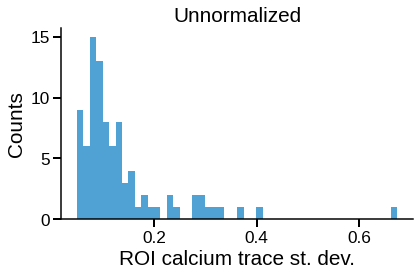

In [11]:
summarize_roi_stds(roi_data, title="Unnormalized")

Thus, depending on our analyses, we may want to normalize the calcium traces for each ROI to make sure they vary within a similar range. We could have done this by calling `get_calcium_traces()` with `scale=True`. However, in this case, we will write our own function, as it will be useful later.

We define a z-scoring function to bring ROI standard deviations more or less within $[-1, 1]$.

In [12]:
def z_score(x, means=None, stds=None):
    if len(x.shape) != 4:
        raise ValueError("x should be a 4D tensor.")

    if means is None:
        means = x.mean(axis=(0, 1, 2)) # all dims, except ROIs
    if stds is None:
        stds = x.std(axis=(0, 1, 2)) # all dims, except ROIs
        
    stds = np.maximum(stds, 1e-4) # avoid exploding values
    
    z = (x - means) / stds        
    return z

Standard deviation range across ROIs (min to max (median)):
    1.0000 to 1.0000 (median: 1.0000)


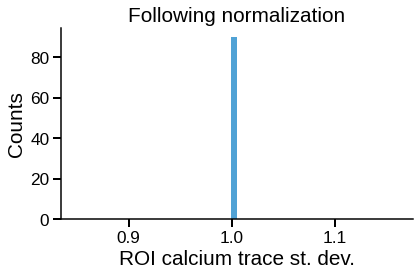

In [13]:
norm_roi_data = z_score(roi_data)
summarize_roi_stds(norm_roi_data, title="Following normalization")

## Calcium traces across three recording days (1 session per day)

Next, we extract data for ROIs tracked across 3 consecutive days by setting `tracked=True` when calling `get_calcium_traces()`.

Here, only data for ROIs that could be tracked across sessions will be returned. In addition, ROI data will be reordered, so that it is consistent across sessions.  

**Notes:**
* ROI tracking was typically done for sessions 1 to 3.  
* ROI indices are _not_ the same across sessions for each tracked ROI, as these indices are session-specific, and generated before we do any tracking.

This function collects data for a mouse across sessions 1 to 3, and returns it in a dictionary called `mouse_data`. 

In [14]:
def collect_data_across_sessions(mouse_n, tracked=True, dataset_path=None):

    mouse_data = dict()
    data_keys = ["sess", "roi_indices", "roi_timestamps", "roi_data", "gabor_seg_dict"]
    for s, sess_n in enumerate(range(1, 4)):
        sess, roi_indices, roi_timestamps, roi_data, gabor_seg_dict = get_calcium_traces(
            sess_n=sess_n, mouse_n=mouse_n, scale=False, tracked=tracked, dataset_path=dataset_path
        )

        mouse_data[f"sess_{sess_n}"] = sess
        mouse_data[f"roi_indices_{sess_n}"] = roi_indices
        mouse_data[f"roi_timestamps_{sess_n}"] = roi_timestamps
        mouse_data[f"roi_data_{sess_n}"] = roi_data
        mouse_data[f"gabor_seg_dict_{sess_n}"] = gabor_seg_dict

    return mouse_data

In [15]:
mouse_data = collect_data_across_sessions(4, tracked=True, dataset_path=dataset_path)
print("\nData is stored under the following keys:\n    - {}".format("\n    - ".join(mouse_data.keys())))


    Session: M4 S1 (L5-Rbp4 soma)
Loading stimulus and alignment info...
Loading ROI trace info...
Loading data for Gabor stimulus...

    Session: M4 S2 (L5-Rbp4 soma)
Loading stimulus and alignment info...
Loading ROI trace info...
Loading data for Gabor stimulus...

    Session: M4 S3 (L5-Rbp4 soma)
Loading stimulus and alignment info...
Loading ROI trace info...
Loading data for Gabor stimulus...

Data is stored under the following keys:
    - sess_1
    - roi_indices_1
    - roi_timestamps_1
    - roi_data_1
    - gabor_seg_dict_1
    - sess_2
    - roi_indices_2
    - roi_timestamps_2
    - roi_data_2
    - gabor_seg_dict_2
    - sess_3
    - roi_indices_3
    - roi_timestamps_3
    - roi_data_3
    - gabor_seg_dict_3


We will now add normalized ROI data to `mouse_dict`. However, we will use our z-scoring function to normalize ROI traces for each tracked ROI **across sessions**, instead of within sessions. (Note that the normalized data is added to `mouse_dict` in place, under a key like `norm_roi_data_1`.)

In [16]:
def add_z_scored_data(mouse_data, plot_stds=True):
    all_roi_data = []
    for sess_n in range(1, 4):
        all_roi_data.append(mouse_data[f"roi_data_{sess_n}"])
    
    n_rois = [roi_data.shape[-1] for roi_data in all_roi_data]
    if len(np.unique(n_rois)) != 1:
        raise ValueError(
            "This function must be used for tracked data, where all sessions have the same number of ROIs."
        )

    all_roi_data = np.concatenate(all_roi_data, axis=0)
    means = all_roi_data.mean(axis=(0, 1, 2))
    stds = all_roi_data.std(axis=(0, 1, 2))

    if plot_stds:
        fig, ax = plt.subplots(ncols=3, figsize=[14, 3.5], sharex=True, sharey=True)
        fig.suptitle("Following normalization")
    for s, sess_n in enumerate(range(1, 4)):
        norm_roi_data = z_score(
            mouse_data[f"roi_data_{sess_n}"], means=means, stds=stds
        )
        mouse_data[f"norm_roi_data_{sess_n}"] = norm_roi_data
        
        if plot_stds:
            summarize_roi_stds(norm_roi_data, title=f"Session {sess_n}", ax=ax[s])

Session 1: Standard deviation range across ROIs (min to max (median)):
    0.5833 to 1.5471 (median: 1.0869)
Session 2: Standard deviation range across ROIs (min to max (median)):
    0.3820 to 1.5626 (median: 0.8624)
Session 3: Standard deviation range across ROIs (min to max (median)):
    0.4183 to 1.4744 (median: 0.9111)


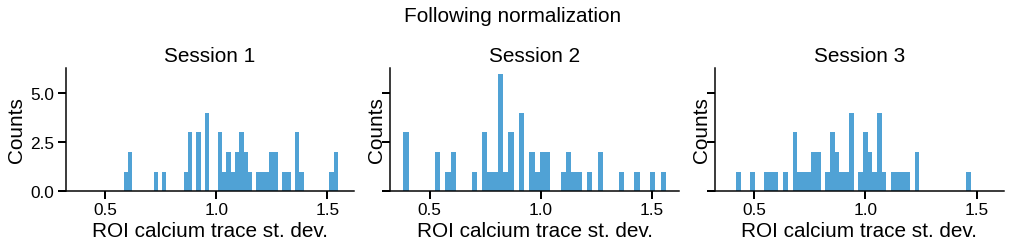

In [17]:
add_z_scored_data(mouse_data)

# 5) Plot the data

Next, we plot the calcium traces for session 1, averaged over neurons and **expected vs unexpected trials**.

In [18]:
def plot_exp_unexp_row(ax_row, data_dict, roi_timestamps, plot_titles=False, set_x=False, y_label=None):

    # get overall timestamps, across all segments
    n_frames = len(roi_timestamps)
    pre = roi_timestamps.min()
    post = (roi_timestamps.max() - roi_timestamps.min()) * len(CONDITIONS)
    roi_timestamps = np.linspace(pre, post, n_frames * len(CONDITIONS)).reshape(len(CONDITIONS), n_frames)
    x_edges = np.linspace(pre, post, len(CONDITIONS) + 1)

    # plot
    for seg_n in range(len(CONDITIONS)):
        sub_ax = ax_row[seg_n]
        if plot_titles: 
            sub_ax.set_title(CONDITIONS[seg_n])

        sub_ax.plot(roi_timestamps[seg_n], data_dict["exp"][seg_n, :], color="green", alpha=0.8, label="expected")
        sub_ax.plot(roi_timestamps[seg_n], data_dict["unexp"][seg_n, :], color="red", alpha=0.8, label="unexpected")

        if set_x:
            sub_ax.set_xlabel("Time (s)")
            sub_ax.set_xticks(np.linspace(x_edges[seg_n], x_edges[seg_n + 1], 3))
        if seg_n == 0 and y_label is not None:
            sub_ax.set_ylabel(y_label)

            
def plot_exp_unexp_traces(mouse_data, sess_ns):
    
    if not isinstance(sess_ns, list):
        sess_ns = [sess_ns]
    height = np.max([3.2, len(sess_ns) * 2])
    
    fig, ax = plt.subplots(
        len(sess_ns), 5, sharex="col", sharey=True, squeeze=False, 
        figsize=[13, height]
    )
    fig.suptitle("Mean calcium traces across ROIs to expected and unexpected trials")
    
    for s, sess_n in enumerate(sess_ns):
        # split data into expected and unexpected, and take average across trials and ROIs, for each session
        unexp = mouse_data[f"gabor_seg_dict_{sess_n}"]["unexpected"][:, 0]
        exp = np.logical_not(unexp)
        
        # retain split data, averaged across ROIs and trials
        data_dict = {
            "exp"  : mouse_data[f"norm_roi_data_{sess_n}"][exp].mean(axis=(0, -1)),
            "unexp": mouse_data[f"norm_roi_data_{sess_n}"][unexp].mean(axis=(0, -1))
        }
        
        # plot
        set_x = (sess_n == sess_ns[-1])
        y_label = f"Norm. dF/F\n(sess. {sess_n})"

        plot_exp_unexp_row(
            ax[s], data_dict, mouse_data[f"roi_timestamps_{sess_n}"], 
            plot_titles=(s == 0), set_x=set_x, y_label=y_label
        )

    ax[-1, 0].legend();

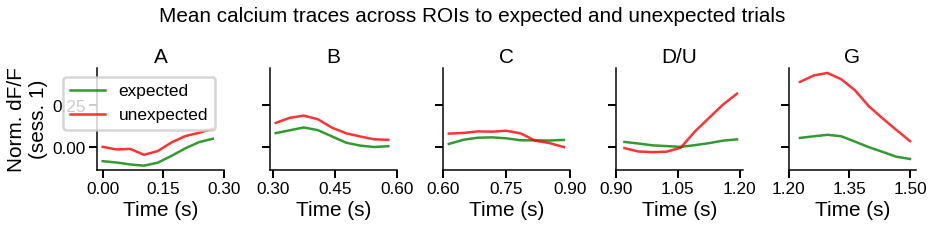

In [19]:
plot_exp_unexp_traces(mouse_data, sess_ns=1)

We can also plot the average traces for all three sessions.

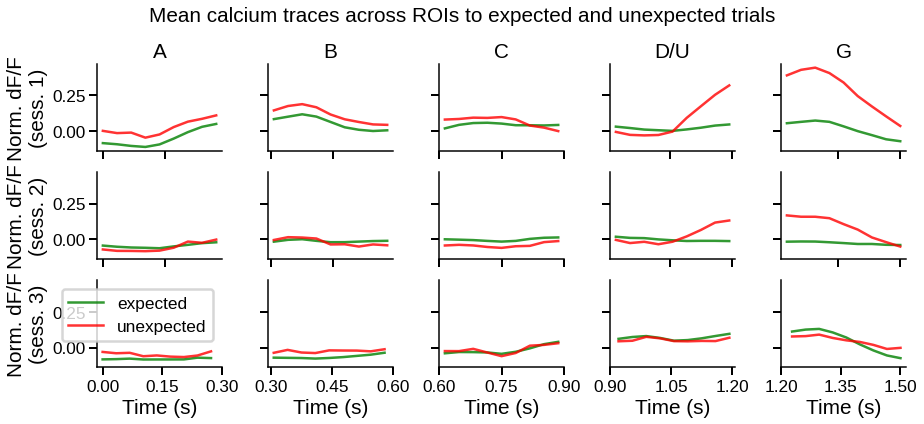

In [20]:
plot_exp_unexp_traces(mouse_data, sess_ns=[1, 2, 3])

# 6) Measure and plot ROI selectivity to expected vs unexpected events

We can also plot the trial-averaged calcium traces for the ROIs that are the most selective to expected (DG) vs unexpected (UG) events.

In [21]:
def calculate_selectivity(data1, data2, axis=None):
    
    mean1, mean2 = [np.mean(data, axis=axis) for data in [data1, data2]]
    std1, std2 = [np.std(data, axis=axis) for data in [data1, data2]]
    numerator = mean2 - mean1
    denom = np.sqrt(0.5 * (std1 ** 2 + std2 ** 2))
    selectivity = numerator / denom
    return selectivity


def get_ROI_exp_unexp_selectivities(mouse_data, sess_n=1):
    
    # identify expected vs unexpected sequences
    unexp = mouse_data[f"gabor_seg_dict_{sess_n}"]["unexpected"][:, 0]
    exp = np.logical_not(unexp)

    # retain DG/UG segments and average across frames
    exp_data = mouse_data[f"norm_roi_data_{sess_n}"][exp][:, -2:].mean(axis=(1, 2))
    unexp_data = mouse_data[f"norm_roi_data_{sess_n}"][unexp][:, -2:].mean(axis=(1, 2))

    # calculate selectivity for each ROI
    selectivities = calculate_selectivity(exp_data, unexp_data, axis=0)
    
    return selectivities


def plot_selective_ROI_exp_unexp_traces(mouse_data, sess_n=1, n_rois=3):
    
    height = np.max([3.2, n_rois * 2])
    fig, ax = plt.subplots(
        n_rois, 5, sharex="col", sharey=True, squeeze=False, 
        figsize=[13, height]
    )
    fig.suptitle("Mean calcium traces across expected and unexpected trials for selective ROIs")
    
    # sort by selectivity
    selectivities = get_ROI_exp_unexp_selectivities(mouse_data, sess_n=sess_n)
    roi_indices = np.argsort(selectivities)[::-1][:n_rois]
   
    # identify expected and unexpected trials
    unexp = mouse_data[f"gabor_seg_dict_{sess_n}"]["unexpected"][:, 0]
    exp = np.logical_not(unexp)
    
    selectivity_strs = []

    for r, roi_idx in enumerate(roi_indices):
        # retain split data, averaged across trials for the identified ROI
        data_dict = {
            "exp"  : mouse_data[f"norm_roi_data_{sess_n}"][exp][..., roi_idx].mean(axis=(0)),
            "unexp": mouse_data[f"norm_roi_data_{sess_n}"][unexp][..., roi_idx].mean(axis=(0))
        }
        
        # plot
        set_x = (r == n_rois - 1)
        
        roi_number = mouse_data[f"roi_indices_{sess_n}"][roi_idx]
        y_label = f"Norm. dF/F\n(ROI #{roi_number})"
        selectivity_strs.append(f"ROI #{roi_number}: {selectivities[roi_idx]:.4f}")
        
        plot_exp_unexp_row(
            ax[r], data_dict, mouse_data[f"roi_timestamps_{sess_n}"], 
            plot_titles=(r == 0), set_x=set_x, y_label=y_label
        )
        
    ax[-1, 0].legend();
    print(",    ".join(selectivity_strs))

ROI #63: 1.7881,    ROI #12: 1.0132,    ROI #67: 0.8613,    ROI #13: 0.7177,    ROI #38: 0.6990


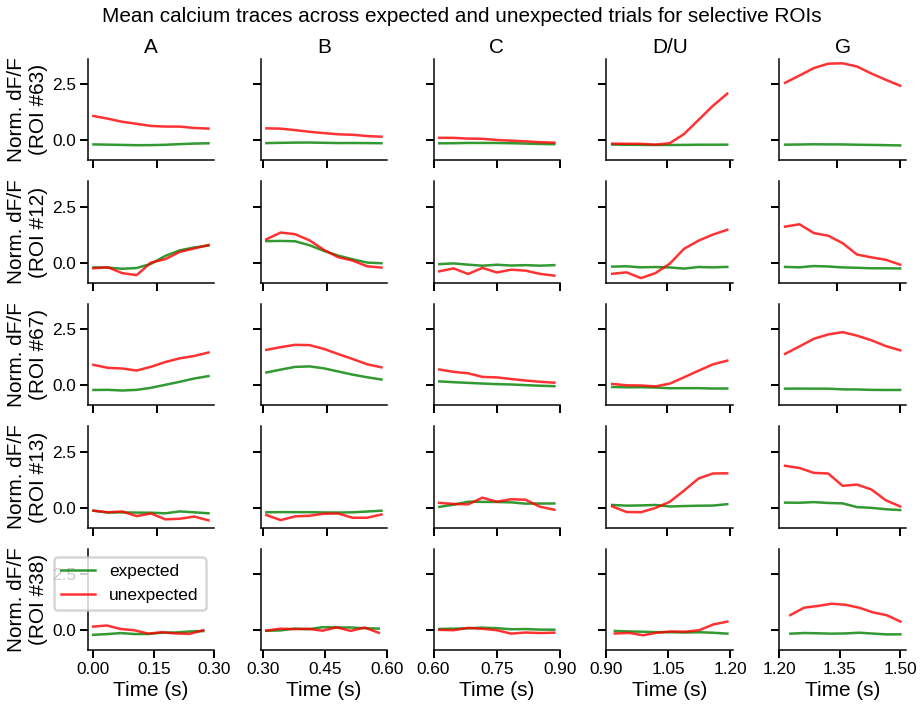

In [22]:
plot_selective_ROI_exp_unexp_traces(mouse_data, sess_n=1, n_rois=5)

As a last result we want to plot the averaged selectivity to unexpected events across days:


In [23]:
def plot_selectivities(mouse_data, sess_ns=1):

    if not isinstance(sess_ns, list):
        sess_ns = [sess_ns]
    
    fig, ax = plt.subplots(ncols=2, figsize=[8, 4], sharex=True, sharey=True)
    fig.suptitle("Mean calcium traces across ROIs to expected and unexpected trials")
    
    selectivities = []
    for s, sess_n in enumerate(sess_ns):
        sess_select = get_ROI_exp_unexp_selectivities(mouse_data, sess_n=sess_n)
        selectivities.append(sess_select)
    
    ax[0].violinplot(selectivities, sess_ns)
    ax[1].plot(sess_ns, np.asarray(selectivities), color="steelblue", alpha=0.7)
    
    ax[0].set_ylabel("Selectivity indices")
    for sub_ax in ax.ravel():
        sub_ax.axhline(y=0, color="k", alpha=0.4, ls=":", zorder=-5)
        sub_ax.set_xticks(sess_ns)
        sub_ax.set_xlabel("Sessions")

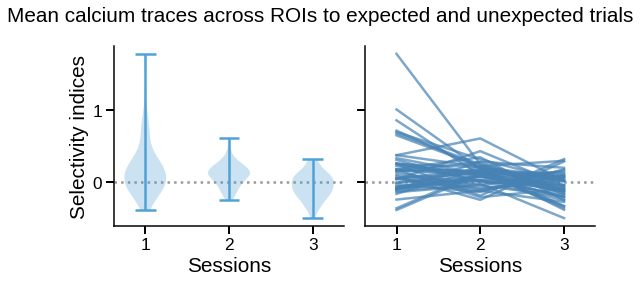

In [24]:
plot_selectivities(mouse_data, sess_ns=[1, 2, 3])